In [1]:
# here for libs
import pandas as pd

In [2]:
# NVIDIA CUDA
import torch
if torch.cuda.is_available():
    print("CUDA is available.")

    num_gpus = torch.cuda.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    
    print(f"Current GPU device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")


CUDA is available.
Number of available GPUs: 1
GPU 0: NVIDIA GeForce RTX 4070 SUPER
Current GPU device: 0


Project plan:
https://docs.google.com/document/d/1o2FlMo1je0yv7LeCV_mMHfmbbjH_XfzrfiKAefOh450/edit

In [3]:
#data import
data = pd.read_csv('./dataset/diabetes_dataset00.csv')
data.head()

,Target,Genetic Markers,Autoantibodies,Family History,Environmental Factors,Insulin Levels,Age,BMI,Physical Activity,Dietary Habits,...,Pulmonary Function,Cystic Fibrosis Diagnosis,Steroid Use History,Genetic Testing,Neurological Assessments,Liver Function Tests,Digestive Enzyme Levels,Urine Test,Birth Weight,Early Onset Symptoms
0,Steroid-Induced Diabetes,Positive,Negative,No,Present,40,44,38,High,Healthy,...,76,No,No,Positive,3,Normal,56,Ketones Present,2629,No
1,Neonatal Diabetes Mellitus (NDM),Positive,Negative,No,Present,13,1,17,High,Healthy,...,60,Yes,No,Negative,1,Normal,28,Glucose Present,1881,Yes
2,Prediabetic,Positive,Positive,Yes,Present,27,36,24,High,Unhealthy,...,80,Yes,No,Negative,1,Abnormal,55,Ketones Present,3622,Yes
3,Type 1 Diabetes,Negative,Positive,No,Present,8,7,16,Low,Unhealthy,...,89,Yes,No,Positive,2,Abnormal,60,Ketones Present,3542,No
4,Wolfram Syndrome,Negative,Negative,Yes,Present,17,10,17,High,Healthy,...,41,No,No,Positive,1,Normal,24,Protein Present,1770,No


## 1.Preprocessing


In [4]:
##check missing data
missing_values = data.isnull().sum()
missing_values[missing_values > 0]


Series([], dtype: int64)

In [5]:
##lable
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()


categorical_columns = ['Genetic Markers', 'Autoantibodies', 'Family History' , 'Environmental Factors', 'Dietary Habits', 'Ethnicity', 'Socioeconomic Factors', 'Smoking Status', 'Alcohol Consumption', 'Glucose Tolerance Test', 'Previous Gestational Diabetes', 'Pregnancy History', 'Cystic Fibrosis Diagnosis', 'Environmental Factors', 'Steroid Use History', 'Genetic Testing', 'Liver Function Tests', 'Urine Test', 'Early Onset Symptoms', 'Physical Activity', 'History of PCOS', 'Target']


for col in categorical_columns:
    data[col] = le.fit_transform(data[col])

output_file_path = './dataset/numeric_diabetes_dataset.csv'
data.to_csv(output_file_path, index=False) 



data.head(50)






,Target,Genetic Markers,Autoantibodies,Family History,Environmental Factors,Insulin Levels,Age,BMI,Physical Activity,Dietary Habits,...,Pulmonary Function,Cystic Fibrosis Diagnosis,Steroid Use History,Genetic Testing,Neurological Assessments,Liver Function Tests,Digestive Enzyme Levels,Urine Test,Birth Weight,Early Onset Symptoms
0,7,1,0,0,1,40,44,38,0,0,...,76,0,0,1,3,1,56,1,2629,0
1,4,1,0,0,1,13,1,17,0,0,...,60,1,0,0,1,1,28,0,1881,1
2,5,1,1,1,1,27,36,24,0,1,...,80,1,0,0,1,0,55,1,3622,1
3,8,0,1,0,1,8,7,16,1,1,...,89,1,0,1,2,0,60,1,3542,0
4,12,0,0,1,1,17,10,17,0,0,...,41,0,0,1,1,1,24,3,1770,0
5,2,1,0,1,1,17,41,26,2,0,...,85,1,0,0,2,1,52,1,3835,1
6,9,0,0,0,0,29,30,31,2,0,...,64,1,1,0,3,0,96,1,4426,0
7,11,1,0,0,0,10,3,18,1,1,...,44,1,0,0,1,1,29,1,1644,1
8,6,0,1,0,0,47,47,25,0,0,...,71,0,1,1,3,1,74,1,3721,0
9,6,1,0,1,1,21,72,24,1,1,...,69,1,1,1,2,0,42,3,4206,0


In [6]:
print(data.describe())


             Target  Genetic Markers  Autoantibodies  Family History  \
count  70000.000000     70000.000000    70000.000000    70000.000000   
mean       5.989729         0.501443        0.499171        0.502400   
std        3.737753         0.500001        0.500003        0.499998   
min        0.000000         0.000000        0.000000        0.000000   
25%        3.000000         0.000000        0.000000        0.000000   
50%        6.000000         1.000000        0.000000        1.000000   
75%        9.000000         1.000000        1.000000        1.000000   
max       12.000000         1.000000        1.000000        1.000000   

       Environmental Factors  Insulin Levels           Age           BMI  \
count           70000.000000    70000.000000  70000.000000  70000.000000   
mean                0.498743       21.607443     32.020700     24.782943   
std                 0.500002       10.785852     21.043173      6.014236   
min                 0.000000        5.000000   

## 2.Validation methods

### 2.1 cross validation

In [7]:
from sklearn.model_selection import train_test_split


X = data.drop('Target', axis=1)
y = data['Target']


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


print(f"train size: {X_train.shape}")
print(f"validation size: {X_val.shape}")
print(f"test size: {X_test.shape}")


train size: (42000, 33)
validation size: (14000, 33)
test size: (14000, 33)


### 2.2 k fold validation

In [8]:
from sklearn.model_selection import KFold


kf = KFold(n_splits=5, shuffle=True, random_state=42)


for train_index, val_index in kf.split(X):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    

    print(f"train size: {X_train.shape}, validation size: {X_val.shape}")


train size: (56000, 33), validation size: (14000, 33)
train size: (56000, 33), validation size: (14000, 33)
train size: (56000, 33), validation size: (14000, 33)
train size: (56000, 33), validation size: (14000, 33)
train size: (56000, 33), validation size: (14000, 33)


### 2.3 Bootstrapping

In [9]:
from sklearn.utils import resample


X_train, y_train = resample(X, y, n_samples=len(X), random_state=42)


X_val = X[~X.index.isin(X_train.index)]
y_val = y[~y.index.isin(y_train.index)]

print(f"train size: {X_train.shape}, val size: {X_val.shape}")


train size: (70000, 33), val size: (25795, 33)


## 3.ML algorithms

### 3.1 Simple algorithms: Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score




model = RandomForestClassifier(n_estimators=100, random_state=42)


model.fit(X_train, y_train)


y_val_pred = model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation accuracy: {val_accuracy}")


y_test_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy}")


Validation accuracy: 0.9049428183756542
Test accuracy: 0.9554285714285714


Experiment 1 - Train size: (56000, 33), Test size: (14000, 33)
Accuracy for experiment 1: 0.903
Experiment 2 - Train size: (56000, 33), Test size: (14000, 33)
Accuracy for experiment 2: 0.904
Experiment 3 - Train size: (56000, 33), Test size: (14000, 33)
Accuracy for experiment 3: 0.903
Experiment 4 - Train size: (56000, 33), Test size: (14000, 33)
Accuracy for experiment 4: 0.903
Experiment 5 - Train size: (56000, 33), Test size: (14000, 33)
Accuracy for experiment 5: 0.905
Experiment 6 - Train size: (56000, 33), Test size: (14000, 33)
Accuracy for experiment 6: 0.900
Experiment 7 - Train size: (56000, 33), Test size: (14000, 33)
Accuracy for experiment 7: 0.904
Experiment 8 - Train size: (56000, 33), Test size: (14000, 33)
Accuracy for experiment 8: 0.900
Experiment 9 - Train size: (56000, 33), Test size: (14000, 33)
Accuracy for experiment 9: 0.899
Experiment 10 - Train size: (56000, 33), Test size: (14000, 33)
Accuracy for experiment 10: 0.909
Experiment 11 - Train size: (56000, 33

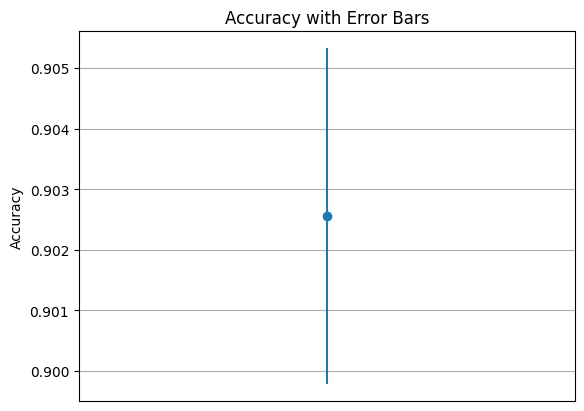

In [14]:
import numpy as np
import matplotlib.pyplot as plt

n_repeats = 20  
accuracies = []


for i in range(n_repeats):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    print(f"Experiment {i+1} - Train size: {X_train.shape}, Test size: {X_test.shape}")
    
   
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
   
    accuracy = model.score(X_test, y_test)
    accuracies.append(accuracy)
    print(f"Accuracy for experiment {i+1}: {accuracy:.3f}")


mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)


print(f"Mean accuracy: {mean_accuracy:.3f}, Standard deviation: {std_accuracy:.3f}")


plt.errorbar(x=[0], y=[mean_accuracy], yerr=[std_accuracy], fmt='o', label='Accuracy with error bar')
plt.title("Accuracy with Error Bars")
plt.ylabel("Accuracy")
plt.xticks([])
plt.grid()
plt.show()



## 4.Experimental results